# Group 16 : Chandana Budaati(1002087323), Sanjana Potluri(1002147971), Deepthi Burada(1002034183), Varshith Konduru(1002132051)

https://colab.research.google.com/drive/1Z0geUoZ9vNtp956w_qHcCoJXNkyy_AzD?usp=sharing

In [ ]:
# Importing required Libraries
import torch
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as td
from torch.autograd import Variable

import random,time
import numpy as np
import matplotlib.pyplot as plt

# Using CUDA for pytorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


#Suggested Method

# Load Dataset

In [ ]:
# Loading the CIFAR10 dataset

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 45975829.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Split and Shuffle the Data

train_split = int(len(trainset)*0.9) # 90% training
trainset, validation_set = torch.utils.data.random_split(trainset, [train_split, len(trainset) - train_split])

# Shuffle the Train Set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True, num_workers=2)


# Implementation

In [ ]:
# Implementing
# Define the values required for sizes batch_size = 64
test_batch_size = 64
input_size = 3072

class PyTorchNN(nn.Module):

    def __init__(self):
        super(PyTorchNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 84, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(84, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 3072),
            nn.ReLU(),
            nn.Linear(3072, 3072),
            nn.ReLU(),
            nn.Linear(3072, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
# Assign GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = PyTorchNN().to(device)
# Inititalize crossEntropy Loss Function
criterion = nn.CrossEntropyLoss()
# Inititalize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002)
print(model)

PyTorchNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 84, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(84, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=16384, out_features=3072, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3072, out_features=3072, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3072, out_features=10, bias=True)
  )
)


In [ ]:
# Training Loop
n_epochs = 100
train_losses, validation_losses, training_accuracies, validation_accuracies= [], [], [], []
lowest_validation_loss = float('inf')
best_model = None

for epoch in range(n_epochs):
    train_loss, validation_loss = 0.0, 0.0
    total_correct, total_examples = 0, 0

    #Model Training
    model.train()
    for img, lbl in trainloader:
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        outputs = model(img)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == lbl).sum().item()
        total_examples += lbl.size(0)

        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    #Training Accuracy calculation
    train_accuracy = total_correct/total_examples*100
    training_accuracies.append(train_accuracy)

    #Model Validation
    model.eval()
    total_correct, total_examples = 0, 0
    for img, lbl in valloader:
        img, lbl = img.to(device), lbl.to(device)
        outputs = model(img)
        loss = criterion(outputs, lbl)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == lbl).sum().item()
        total_examples += lbl.size(0)

        validation_loss += loss.item()
    #Validation Accuracy calculation
    validation_accuracy = total_correct/total_examples*100
    validation_accuracies.append(validation_accuracy)

    train_losses.append(train_loss/len(trainloader))
    validation_losses.append(validation_loss/len(valloader))

    #Saving the Best Model
    if validation_loss < lowest_validation_loss:
        lowest_validation_loss = validation_loss
        best_model = model.state_dict()

    print(f'Epoch: {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.4f}')
    print(f'\t Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.4f}')

Epoch: 1, Training Loss: 1.5511, Training Accuracy: 43.7200
	 Validation Loss: 1.2180, Validation Accuracy: 56.8600
Epoch: 2, Training Loss: 1.0335, Training Accuracy: 63.2556
	 Validation Loss: 1.0375, Validation Accuracy: 64.5800
Epoch: 3, Training Loss: 0.7879, Training Accuracy: 72.4578
	 Validation Loss: 0.8039, Validation Accuracy: 71.8600
Epoch: 4, Training Loss: 0.5891, Training Accuracy: 79.3778
	 Validation Loss: 0.7631, Validation Accuracy: 73.9000
Epoch: 5, Training Loss: 0.3991, Training Accuracy: 86.1422
	 Validation Loss: 0.8262, Validation Accuracy: 73.3400
Epoch: 6, Training Loss: 0.2225, Training Accuracy: 92.3533
	 Validation Loss: 0.8660, Validation Accuracy: 74.7600
Epoch: 7, Training Loss: 0.1213, Training Accuracy: 95.8756
	 Validation Loss: 0.9939, Validation Accuracy: 75.1800
Epoch: 8, Training Loss: 0.0760, Training Accuracy: 97.4600
	 Validation Loss: 1.0514, Validation Accuracy: 76.4800
Epoch: 9, Training Loss: 0.0545, Training Accuracy: 98.2933
	 Validation

In [ ]:
# Load the model
model.load_state_dict(best_model)

<All keys matched successfully>

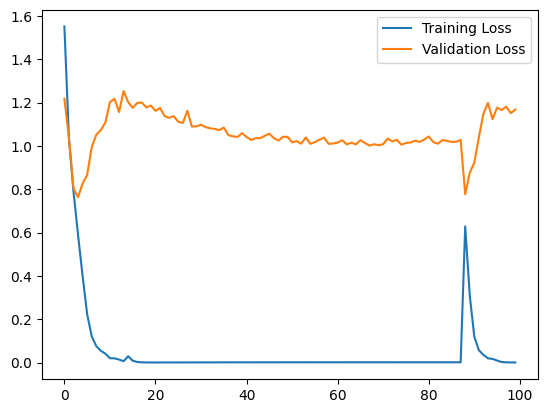

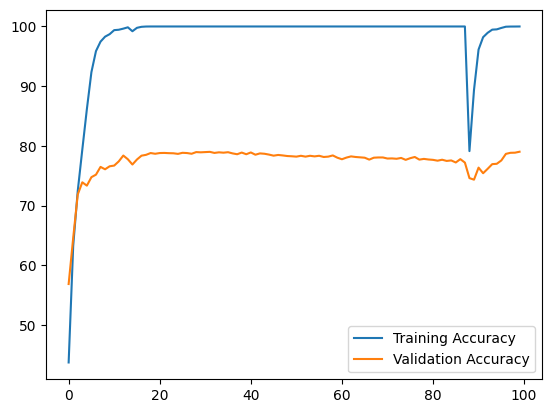

In [ ]:
# Plot train and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()
plt.show()

# plot train and validation accuracy
plt.figure()
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

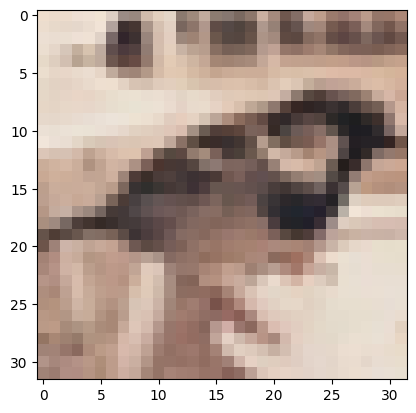

Predicted Label: cat :: Original Label: bird


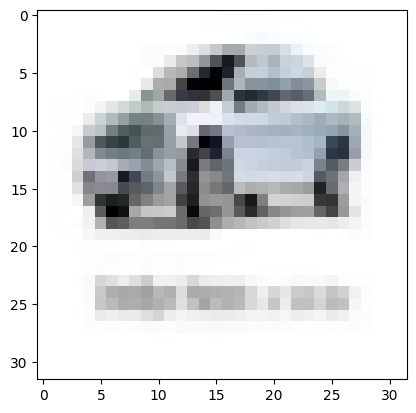

Predicted Label: car :: Original Label: car


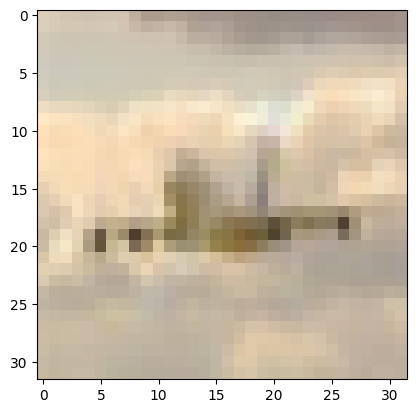

Predicted Label: plane :: Original Label: plane


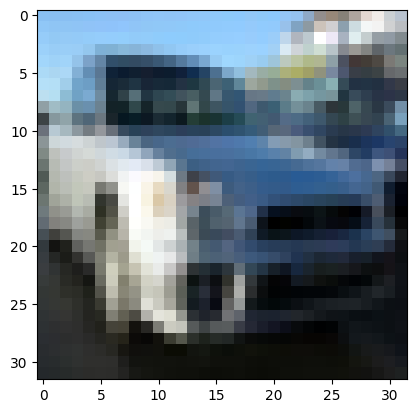

Predicted Label: car :: Original Label: car


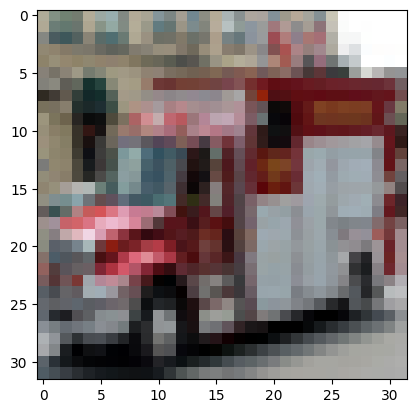

Predicted Label: truck :: Original Label: truck


In [ ]:
# Predict the images

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def predict(model, img):
    model.eval()
    img = img.unsqueeze_(0)
    img = img.to(device)

    with torch.no_grad():
        output = model(img)

    probabilities = torch.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, dim=1)

    return predicted_class.item()

# labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# testloader with batch size of 1
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)

# Print the predicted images
for i, (img, lbl) in enumerate(testloader):
    if i>=5:
        break
    imshow(img[0])
    predicted_class = predict(model, img[0])
    print(f'Predicted Label: {classes[predicted_class]} :: Original Label: {classes[lbl]}')

#**Improvised Method 1**



In [ ]:
# Load the dataset

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split and Shuffle the Data

train_split = int(len(trainset)*0.9) # 90% training
trainset, validation_set = torch.utils.data.random_split(trainset, [train_split, len(trainset) - train_split])

#Shuffle the Train Set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True, num_workers=2)


In [ ]:
# Define the values required for sizes

batch_size = 64
test_batch_size = 64
input_size = 3072

# Define class PyTorchNN_Method1

class PyTorchNN_Method1(nn.Module):
    def __init__(self):
        super(PyTorchNN_Method1, self).__init__()

        self.conv1 = nn.Conv2d(3, 84, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(84)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(84, 256, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Setup Fully Connect Layer
        self.fc1 = nn.Linear(256,3072)
        self.fc2 = nn.Linear(3072,3072)
        self.fc3 = nn.Linear(3072,10)
# Define forward
    def forward(self, x):

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [ ]:
# Assign GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Model Initialize
model1 = PyTorchNN_Method1().to(device)
# Inititalization crossEntropy Loss Function
criterion = nn.CrossEntropyLoss()
# Inititalize Optimizer
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002)
print(model1)

PyTorchNN_Method1(
  (conv1): Conv2d(3, 84, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(84, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [ ]:
# Training Loop
n_epochs = 100
train_losses, validation_losses, training_accuracies, validation_accuracies= [], [], [], []
lowest_validation_loss = float('inf')
best_model = None

for epoch in range(n_epochs):
    train_loss, validation_loss = 0.0, 0.0
    total_correct, total_examples = 0, 0
    model1.train()
    for img, lbl in trainloader:
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        outputs = model1(img)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == lbl).sum().item()
        total_examples += lbl.size(0)

        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_accuracy = total_correct/total_examples*100
    training_accuracies.append(train_accuracy)

    model1.eval()
    total_correct, total_examples = 0, 0
    for img, lbl in valloader:
        img, lbl = img.to(device), lbl.to(device)
        outputs = model1(img)
        loss = criterion(outputs, lbl)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == lbl).sum().item()
        total_examples += lbl.size(0)

        validation_loss += loss.item()

    validation_accuracy = total_correct/total_examples*100
    validation_accuracies.append(validation_accuracy)

    train_losses.append(train_loss/len(trainloader))
    validation_losses.append(validation_loss/len(valloader))

    if validation_loss < lowest_validation_loss:
        lowest_validation_loss = validation_loss
        best_model = model1.state_dict()

    print(f'Epoch: {epoch+1/n_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.4f}')
    print(f'\t Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.4f}')

Epoch: 1, Training Loss: 1.2583, Training Accuracy: 54.3200
	 Validation Loss: 1.0849, Validation Accuracy: 61.5000
Epoch: 2, Training Loss: 0.8312, Training Accuracy: 70.7489
	 Validation Loss: 0.8886, Validation Accuracy: 68.6800
Epoch: 3, Training Loss: 0.6372, Training Accuracy: 77.7156
	 Validation Loss: 0.8862, Validation Accuracy: 70.0200
Epoch: 4, Training Loss: 0.5107, Training Accuracy: 82.1422
	 Validation Loss: 0.7310, Validation Accuracy: 75.4800
Epoch: 5, Training Loss: 0.4017, Training Accuracy: 86.0689
	 Validation Loss: 0.7141, Validation Accuracy: 76.0800
Epoch: 6, Training Loss: 0.3245, Training Accuracy: 88.6111
	 Validation Loss: 0.7475, Validation Accuracy: 76.9800
Epoch: 7, Training Loss: 0.2576, Training Accuracy: 90.9711
	 Validation Loss: 0.8036, Validation Accuracy: 76.6000
Epoch: 8, Training Loss: 0.2015, Training Accuracy: 92.8600
	 Validation Loss: 0.7463, Validation Accuracy: 78.9000
Epoch: 9, Training Loss: 0.1508, Training Accuracy: 94.7511
	 Validation

# Load fit model


In [ ]:
model1.load_state_dict(best_model)

<All keys matched successfully>

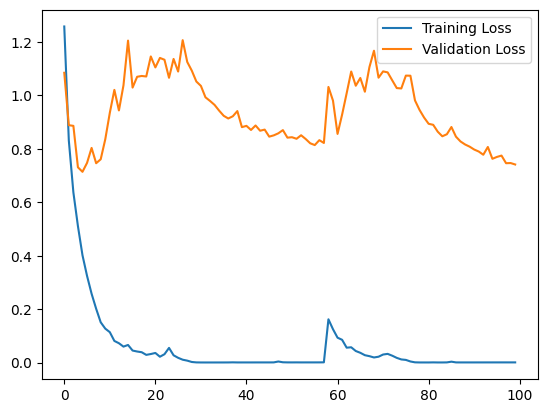

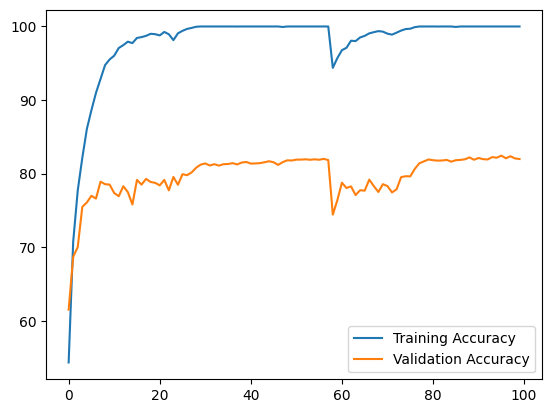

In [ ]:
# Plot train and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()
plt.show()

# Plot train and validation accuracies
plt.figure()
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

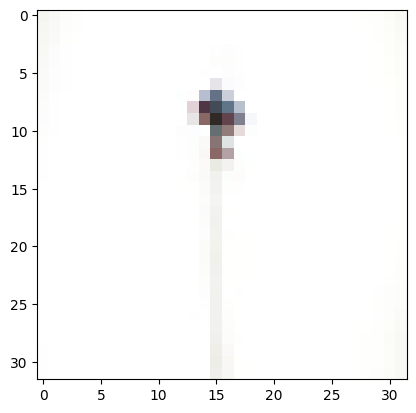

Predicted Label: bird :: Original Label: plane


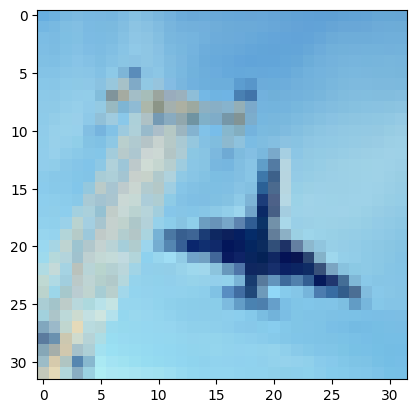

Predicted Label: plane :: Original Label: plane


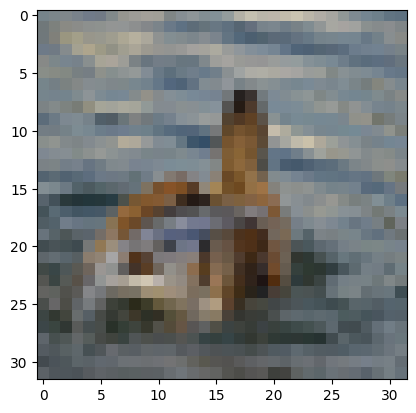

Predicted Label: truck :: Original Label: bird


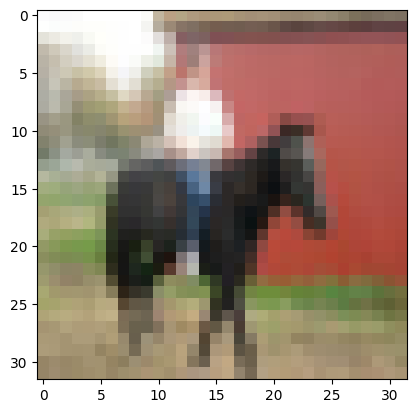

Predicted Label: horse :: Original Label: horse


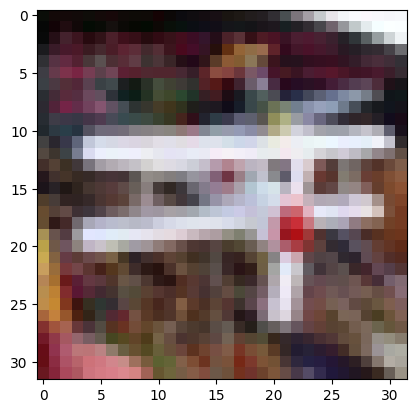

Predicted Label: car :: Original Label: plane


In [ ]:
#Predict the images
for i, (img, lbl) in enumerate(testloader):
    if i>=5:
        break
    imshow(img[0])
    predicted_class = predict(model1, img[0])
    print(f'Predicted Label: {classes[predicted_class]} :: Original Label: {classes[lbl]}')

#**Improvised Method 2 : Experimental**


# Loading Data

In [ ]:
#  Modification to transform Data Augmentation
# Include RandomRodation and RandomHorizontalFlip functions
transform = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.RandomRotation(20),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_split = int(len(trainset)*0.9) # 90% training
trainset, validation_set = torch.utils.data.random_split(trainset, [train_split, len(trainset) - train_split])

#Shuffling Training Set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Implementation

In [ ]:
# Define PyTorchNN_Method2
class PyTorchNN_Method2(nn.Module):
    def __init__(self):
        super(PyTorchNN_Method2, self).__init__()


        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(), #switched from ReLU to LeakyReLU
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
# Use Cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = PyTorchNN_Method2().to(device)

criterion = nn.CrossEntropyLoss()

# Switch SGD to Adam optimizer
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Add auto train termination
n_epochs_stop = 20
min_validation_loss = np.Inf
epochs_no_improve = 0

In [ ]:
# Model Training

# Training Loop
n_epochs = 100
train_losses, validation_losses, training_accuracies, validation_accuracies= [], [], [], []
lowest_validation_loss = float('inf')
best_model = None

for epoch in range(n_epochs):
    train_loss, validation_loss = 0.0, 0.0
    total_correct, total_examples = 0, 0
    model2.train()
    for img, lbl in trainloader:
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        outputs = model2(img)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == lbl).sum().item()
        total_examples += lbl.size(0)

        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_accuracy = total_correct/total_examples*100
    training_accuracies.append(train_accuracy)

    model2.eval()
    total_correct, total_examples = 0, 0
    for img, lbl in valloader:
        img, lbl = img.to(device), lbl.to(device)
        outputs = model2(img)
        loss = criterion(outputs, lbl)

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == lbl).sum().item()
        total_examples += lbl.size(0)

        validation_loss += loss.item()

    validation_accuracy = total_correct/total_examples*100
    validation_accuracies.append(validation_accuracy)

    train_losses.append(train_loss/len(trainloader))
    validation_losses.append(validation_loss/len(valloader))


    if validation_loss >= min_validation_loss:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
        break
    else:
        epochs_no_improve = 0
        min_validation_loss = validation_loss

    if validation_loss < lowest_validation_loss:
        lowest_validation_loss = validation_loss
        best_model = model2.state_dict()

    print(f'Epoch: {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.4f}')
    print(f'\t Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.4f}')

Epoch: 1/100, Training Loss: 1.6484, Training Accuracy: 39.1222
	 Validation Loss: 1.3411, Validation Accuracy: 51.8600
Epoch: 2/100, Training Loss: 1.3331, Training Accuracy: 51.9667
	 Validation Loss: 1.1949, Validation Accuracy: 56.2000
Epoch: 3/100, Training Loss: 1.1639, Training Accuracy: 58.9444
	 Validation Loss: 1.0393, Validation Accuracy: 63.9200
Epoch: 4/100, Training Loss: 1.0614, Training Accuracy: 63.2978
	 Validation Loss: 0.9563, Validation Accuracy: 66.8600
Epoch: 5/100, Training Loss: 0.9668, Training Accuracy: 66.7733
	 Validation Loss: 0.8826, Validation Accuracy: 69.3400
Epoch: 6/100, Training Loss: 0.8861, Training Accuracy: 69.8756
	 Validation Loss: 0.8371, Validation Accuracy: 70.6200
Epoch: 7/100, Training Loss: 0.8271, Training Accuracy: 71.9333
	 Validation Loss: 0.7651, Validation Accuracy: 74.1400
Epoch: 8/100, Training Loss: 0.7634, Training Accuracy: 74.1733
	 Validation Loss: 0.7792, Validation Accuracy: 73.5400
Epoch: 9/100, Training Loss: 0.7221, Tra

In [ ]:
# @title Loading Perfectly Fit Model
model2.load_state_dict(best_model)

<All keys matched successfully>

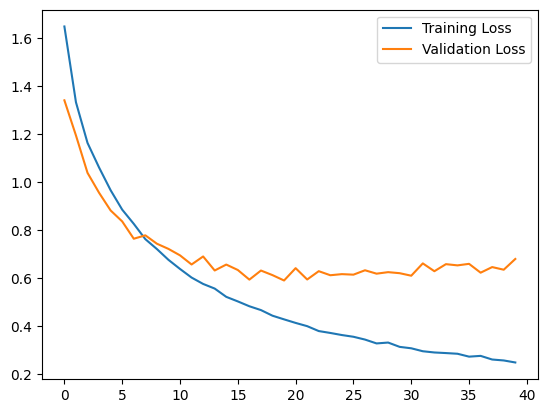

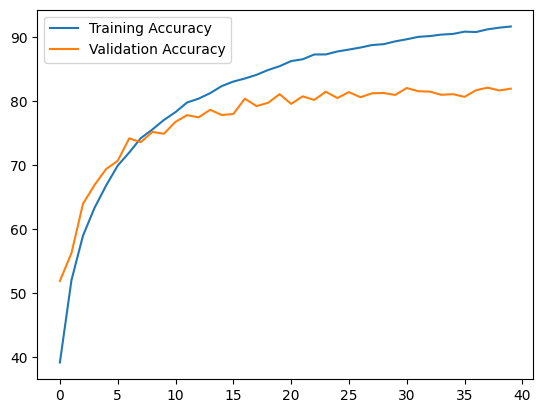

In [ ]:
# Plot of train loss, validation loss, Train, accuracy, Validation accuracy

# Plot train and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()
plt.show()

# Plot train and validation accuracy
plt.figure()
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

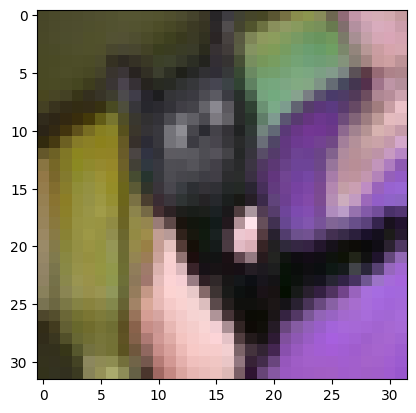

Predicted Label: cat :: Original Label: cat


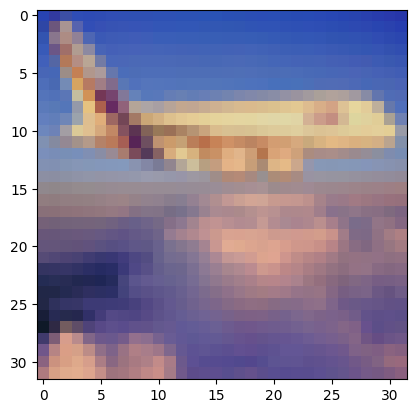

Predicted Label: plane :: Original Label: plane


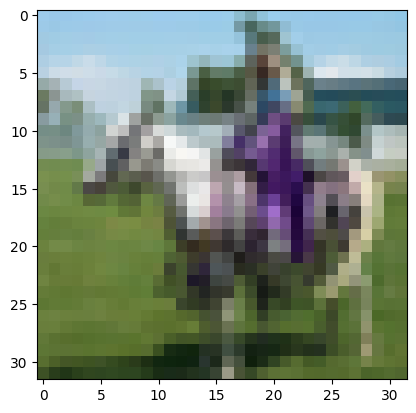

Predicted Label: horse :: Original Label: horse


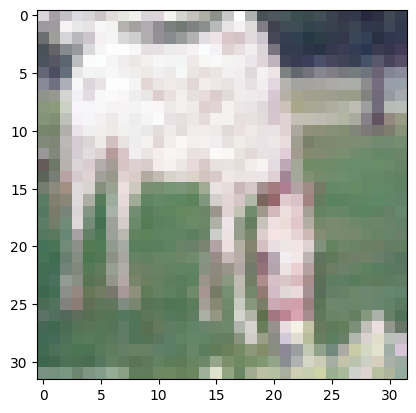

Predicted Label: horse :: Original Label: horse


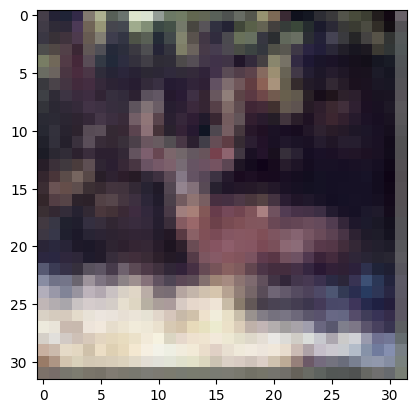

Predicted Label: deer :: Original Label: deer


In [ ]:
# Predict the images
for i, (img, lbl) in enumerate(testloader):
    if i>=5:
        break
    imshow(img[0])
    predicted_class = predict(model2, img[0])
    # Print the predicted image
    print(f'Predicted Label: {classes[predicted_class]} :: Original Label: {classes[lbl]}')